## In this notebook I will create a CNN for Environmental Sound Classification, using the public dataset UrbanSound8K. The arquitecture and the hyperparameters are based on Juan Pablo Bello's implementation 
I will train a CNN to classify sounds out of 10 different classes. I will do that with different number of examples to see how this affects training. <br>
I will train it with different features (spectrogram and MFCCs) to see how this affects training.<br>
Additional things to try:  Autoencoder, Data augmentation



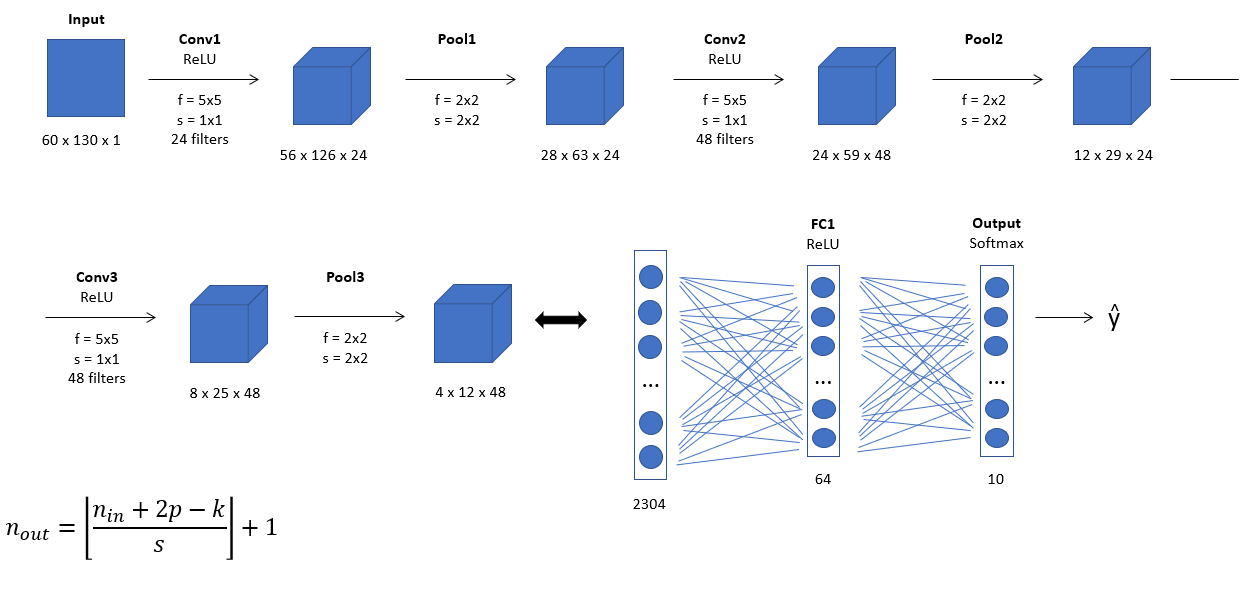

In [1]:
#from IPython.display import Image
#Image(filename = r"C:\Users\Santiago\Desktop\Application Noise Map\Master Thesis\Pictures for Latex document\Arquitecture_BuyllaNET.png")


In [1]:
import my_modules_v2 as my
import imp 
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split

from tensorflow.python.framework import ops

from cnn_utils import * # random mini batches
from datetime import datetime
#from my_modules import get_var

#def get_var(name):

#    for i in range(len(all_vars)):
#        if all_vars[i].name.startswith(name):
#            return all_vars[i]
#    return None
print('Hola_radiola')

#### Writing and running programs in TensorFlow has the following steps:

1. Create Tensors (variables) that are not yet executed/evaluated. <br>
2. Write operations between those Tensors. <br>
3. Initialize your Tensors.<br>
4. Create a Session.<br>
5. Run the Session. This will run the operations you'd written above.

In [3]:
# Example

y_hat = tf.constant(36, name='y_hat')            # Define y_hat constant. Set to 36.
y = tf.constant(39, name='y')                    # Define y. Set to 39

loss = tf.Variable((y - y_hat)**2, name='loss')  # Create a variable for the loss

init = tf.global_variables_initializer()         # When init is run later (session.run(init)),
                                                 # the loss variable will be initialized and ready to be computed
with tf.Session() as session:                    # Create a session and print the output
    session.run(init)                            # Initializes the variables
    print(session.run(loss))                     # Prints the loss

9


## Let's start with our Neural Network
Here are some of the parameters that I am going to use:
> __Layers__ <br> 3 Conv layers + 3 Max-Pooling layers + 2 FC layers <br> layer1.shape = (5,5,1,24), that is f=5, n_C=1, #filters = 24; followed by __max-pooling__ (2x2,2x2) where (f,s), and ReLU activation <br> layer2.shape = (5,5,24,48), __max-pooling__ (2x2,2x2), ReLU activation function <br> layer3.shape = (5,5,48,48) ,__max-pooling__ (2x2,2x2), ReLU activation <br> layer4.shape = (64,2304), FC layer with 64 hidden units followed by ReLU activation function <br> layer5.shape = (10,64), 10 hidden units, Softmax activation function. <br> 'VALID' padding is used throughout the whole network 
<br><br> __Hyperparameters__ <br> Loss function: cross-entropy loss via mini-batch stochastic GD <br> Batch size: 100 TF patches, 3 s duration (randomly selected from the 4s of each audio clip) <br> Learning rate: 0.01 (constant) <br> Dropout: applied to the input of layers 4&5, with p = 0.5 <br> L2 regularization is applied to the weights of the last 2 layers, penalty factor = 0.001<br>  Number of epochs: 50<br> <br>
__Input to the network__ <br> TF patches from the log-scaled mel-spectogram representation of the audio signal. Duration = 3 seconds. Randomly extracted from the full log-melspectrogram of each audio <br> 
For 135 training examples, it took 31.45 minutes for the network to train, without normalizing the inputs. <br>
For 135 training examples, it took 33.33 minutes for the network to train, normalizing the inputs. <br>
For 67 training examples, it took 19 minutes for the network to train. (Always with normalization from now on)


    

## 1.1 Load dataset and normalize inputs

In [2]:
# LOAD DATASET
X = np.load(r'/home/santiago/training_try1/features_mel.npy')
Y = np.load(r'/home/santiago/training_try1/labels.npy')

X= np.transpose(X, axes =(2,0,1))
print(X.shape)
print(Y.shape)
# SPLIT DATASET INTO TRAINING/TEST SETS - I will train on 8 folders and use 1 for testing. 
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 6, random_state = 5, shuffle = False, stratify = None )
# Comment: shuffle is set to false because the files were already randomized when saving them into folders. If I shuffle
# them again, I might mix files from the same slice/ocurrence between test and train sets, making accuracy higher in a 
# wrong way (cheating). When taking minibatches from X_train, that is okey if I shuffle them since that is already going
# to be the unspoiled training set, 873 in first folder
files_per_folder = [873, 888, 925, 990, 936, 823, 838, 806, 816, 837]
idx_folder_testing = 0
X_train = X[files_per_folder[idx_folder_testing]:,:,:]
Y_train = Y[files_per_folder[idx_folder_testing]:]
X_test = X[0:files_per_folder[idx_folder_testing]:,:,:]
Y_test = Y[0:files_per_folder[idx_folder_testing]:]


X_train = np.transpose(np.array(X_train, ndmin = 4), axes = (1,2,3,0))
X_test = np.transpose(np.array(X_test, ndmin = 4), axes = (1,2,3,0))
#Common pitfall. An important point to make about the preprocessing is that any preprocessing statistics (e.g. the data mean)
#must only be computed on the training data, and then applied to the validation / test data. E.g. computing the mean and 
#subtracting it from every image across the entire dataset and then splitting the data into train/val/test splits would be
#a mistake. Instead, the mean must be computed only over the training data and then subtracted equally from all 
#splits (train/val/test). http://cs231n.github.io/neural-networks-2/

# NORMALIZE INPUTS TO HAVE MEAN = 0 AND VARIANCE = 1
X_train = (X_train-np.mean(X_train))/np.std(X_train)
X_test = (X_test-np.mean(X_train))/np.std(X_train)   # apply the same transformation to the test data


# ONE HOT ENCODING OF THE LABELS
Y_train = np.transpose(convert_to_one_hot(Y_train, 10))
Y_test = np.transpose(convert_to_one_hot(Y_test, 10))


# PRINT SOME INFORMATION ABOUT THE TRAIN/TEST SETS
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))




(27, 60, 130)
(27,)
number of training examples = 19
number of test examples = 8
X_train shape: (19, 60, 130, 1)
Y_train shape: (19, 10)
X_test shape: (8, 60, 130, 1)
Y_test shape: (8, 10)


## 1.2 Create placeholders

## 1.3 Initialize parameters

## 1.4 Forward propagation

## 1.5 Compute cost

## 1.6 Model

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True, keep_prob = 1, lambd = 0, t = 0):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> FLATTEN -> FULLYCONNECTED -> RELU -> SOFTMAX
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 1)
    Y_train -- test set, of shape (None, n_y = 10)
    X_test -- training set, of shape (None, 64, 64, 1)
    Y_test -- test set, of shape (None, n_y = 10)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 5 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    
    No need to worry about bias variables since TensorFlow functions take care of the bias. 
    Note also that we will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the
    layers for the fully connected part automatically. 
    """
    
    tf.reset_default_graph()                          # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    m, n_H0, n_W0, n_C0 = X_train.shape
    
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders 
    X, Y = my.create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    if keep_prob == 1:
        Z5, parameters = my.forward_propagation(X)
    else:
        Z5, parameters = my.forward_propagation_with_dropout(X, keep_prob)
        
    # Cost function: Add cost function to tensorflow graph
    
    if lambd == 0:
        cost = my.compute_cost(Z5, Y)
    else:
        cost = my.compute_cost_with_regularization(Z5, Y, parameters, lambd)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost. 
    # Calling minimize() takes care of both computing the gradients and applying them to the variables.
    # Argument var_list: Optional list or tuple of Variable objects to update to minimize loss. Defaults to the 
    #list of variables collected in the graph under the key GraphKeys.TRAINABLE_VARIABLES
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Create a save instance in order to save our trained variables and the graph definition
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir0 = r'/home/santiago/training_try1/Saved_model'
    logdir0 = "{}/saved_model_run-{}/".format(root_logdir0, now)
    builder = tf.saved_model.builder.SavedModelBuilder(logdir0)
    
    # Creates summaries for Tensorboard
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = r'/home/santiago/training_try1/Saved_model'
    logdir = "{}/event_run-{}/".format(root_logdir, now)
    
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(Z5, 1), tf.argmax(Y, 1)) # Returns the truth value of (x == y) element-wise.
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))  # Casts a tensor to a new type.
        tf.summary.scalar('accuracy', accuracy)
        
    file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
    merged_summary = tf.summary.merge_all()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatches_cost = 0
            seed = seed + 1
            minibatches_train = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            num_minibatches_train = len(minibatches_train)

            for minibatch in minibatches_train:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                                
                minibatches_cost += minibatch_cost    # Cost per minibatch
                
            epoch_cost = minibatches_cost / num_minibatches_train  # Cost per epoch
            
            t_elapsed = time.time() - t
            
            if print_cost == True and epoch % 5 == 0:      # Print the cost
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("Time elapsed: %i" % t_elapsed)
                
            if epoch % 1 == 0:                             # Append the cost
                costs.append(epoch_cost)
                
            if epoch % 1 == 0:                             # Write summaries
                summary_str = merged_summary.eval(feed_dict={X:minibatch_X, Y:minibatch_Y})
                file_writer.add_summary(summary_str, epoch)
                
        # add the meta graph and variables to the builder instance      
        builder.add_meta_graph_and_variables(sess,
                                       [tf.saved_model.tag_constants.TRAINING],
                                       signature_def_map=None,
                                       assets_collection=None)
        
        # save the builder instance, containing variables and graph
        builder.save() 
        
        # close the file_writer for tensorboard
        file_writer.close()

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
     
        # Let's calculate the accuracy previously defined above
        # Split into batches for prediction, otherwise memory problems appear due to huge matrix sizes

        train_accuracy = 0
        test_accuracy = 0
        
        for minibatch_train in minibatches_train:
            (minibatch_X_train, minibatch_Y_train) = minibatch_train
            train_accuracy += accuracy.eval({X: minibatch_X_train, Y: minibatch_Y_train})
        
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})      
        train_accuracy = train_accuracy/num_minibatches_train
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.453316
Time elapsed: 1
Cost after epoch 5: 1.409555
Time elapsed: 3
Cost after epoch 10: 6.353737
Time elapsed: 5
Cost after epoch 15: 0.742512
Time elapsed: 6
Cost after epoch 20: 0.700303
Time elapsed: 8
Cost after epoch 25: 0.379313
Time elapsed: 10
Cost after epoch 30: 0.100608
Time elapsed: 12
Cost after epoch 35: 0.124152
Time elapsed: 14
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'C:\\Users\\Santiago\\deep-machine-learning\\UrbanSound8K_Treated\\Deprueba/saved_model_run-20180325111407/saved_model.pb'


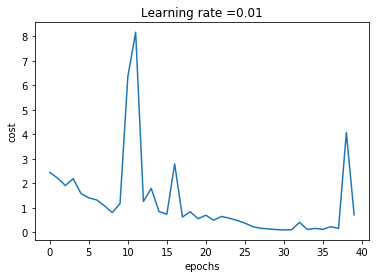

Train Accuracy: 0.633333337307
Test Accuracy: 0.125
Time elapsed: 17.028391361236572


In [10]:
# Run the whole thing

t = time.time()

_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.01,
          num_epochs=50, minibatch_size=100, keep_prob = 0.5, lambd = 0.001, t = t)

        
elapsed = time.time() - t

print ('Time elapsed: %s' %elapsed)